In [34]:
import pandas as pd
import numpy as np
from sklearn.decomposition import NMF
from sklearn.preprocessing import normalize
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from scipy.stats import spearmanr
from scipy.stats import pearsonr
from scipy.optimize import nnls

In [35]:
def read_yu_data():
    '''Read county demographic data into dataframe with contyFIPS as index'''
    
    data = pd.read_csv('yu_data_NO_AHRF.csv')
    data.set_index('countyFIPS', inplace=True)
    return data

In [36]:
def clean_for_nmf(df,*, max_nas = 50):
    '''Clean data frame for NMF.  
    (i) Removes non-numeric and negative features
    (ii) deletes features with more thatn max_nas nan/inf values 
    (iii) replaces missing values with feature median
    (iv) normalizes columns
    (v) sorts by FIPS
    '''
    
    clean_df = df.select_dtypes([np.number])
    clean_df = clean_df.replace(np.inf, np.nan)
    clean_df = clean_df.loc[:, (df.isnull().sum(axis=0) <= max_nas)]
    clean_df = clean_df.fillna(clean_df.median(axis=0))
    clean_df = clean_df.loc[:, (clean_df > 0).all('rows')]
    clean_df = pd.DataFrame(normalize(clean_df, axis=0), 
                  columns=clean_df.columns, index=clean_df.index)
    clean_df = clean_df.sort_index()
    return clean_df

In [37]:
def get_covid_column(feature):
    '''Returns normalized column from jh_covid.csv index by FIPS code'''
    covid_data = pd.read_csv('jh_covid.csv')
    covid_data.set_index('FIPS', inplace=True)
    covid_col = covid_data[[feature]]
    covid_col = covid_col.reset_index().dropna().set_index('FIPS')
    covid_col = pd.DataFrame(normalize(covid_col, axis=0), columns=covid_col.columns, index=covid_col.index)
    covid_col = covid_col.sort_index()
    return covid_col

In [38]:
def run_NMF(df, *, num_topics):
    df_matrix = df.to_numpy()    
    NMF_model = NMF(n_components=num_topics, init='random', random_state=1, max_iter=10000)
    weights = NMF_model.fit_transform(df_matrix)
    topics = NMF_model.components_
    error = NMF_model.reconstruction_err_
    
    #display("error:", error)

    return pd.DataFrame(data=topics, columns=df.columns), weights

In [72]:
def weightedNMF(demo, covid_col, *, lmbda, num_topics):
    demo_covid = pd.concat([lmbda*covid_col, demo], axis=1, sort=False)    
    demo_covid = demo_covid.loc[demo_covid.notnull().all(axis=1), :] #ignore counties that are left out of either data set
    
    #display("demo_covid", demo_covid)
    
    topics, weights = run_NMF(demo_covid, num_topics = num_topics)
    
    topics_tr = topics.transpose()
    
    #display(topics_tr)
    
    covid_scores = np.reshape(topics_tr.iloc[:1 , :].to_numpy(), (-1)) /lmbda
    
    #display(covid_scores)
    
    trimmed_topics = topics_tr.iloc[1:, :] #CHECK THE INDICES HERE AND ABOVE!
    
   #display(trimmed_topics)
    
    return trimmed_topics, covid_scores

In [40]:
def topic_covid_display(topics, N):
    '''*deprecated* Assumes covid in first column'''

    topics_tr = topics.transpose()

    covid_weights = topics_tr.iloc[:1 , :]
    trimmed_topics = topics_tr.iloc[1:, :]

    for top in trimmed_topics.columns:
        print("Topic ", top,":")
        print("Covid importance: ", covid_weights.iloc[0][top])
        print(trimmed_topics.nlargest(N, top).index.values) #cleaner way?
        print()

In [41]:
def do_inference(county_row, topics, importance_scores):
    '''county row is numpy array
    topics is numpy array - topics should be columns
    '''
    topic_weights, residual = nnls(topics, county_row) #infers a representation of the county as a combination of topics
    
    return np.dot(topic_weights, importance_scores)

In [42]:
def normalize_columns(df):
    return pd.DataFrame(normalize(df, axis=0), columns=df.columns, index=df.index)

In [43]:
def training_test_data(demo_data, covid_col, test_frac=0.2):
    
    demo_clean = clean_for_nmf(demo_data, max_nas=100)
    
    covid_merged = pd.concat([covid_col, demo_clean], axis=1)
        
    #ignore counties that are left out of either data set
    covid_merged = covid_merged.loc[covid_merged.notnull().all(axis=1), :] 
        
    merged_train, merged_test = train_test_split(covid_merged, test_size=test_frac)    
    
    demo_train = pd.DataFrame(merged_train.iloc[:, 1:])    
    covid_train = pd.DataFrame(merged_train.iloc[:,0])
    
    demo_test = pd.DataFrame(merged_test.iloc[:, 1:])
    covid_test = pd.DataFrame(merged_test.iloc[:, 0])
        
    #ensure that test are training data are normalized separately
    clean_train = normalize_columns(demo_train)
    clean_test = normalize_columns(demo_test)
    

    return (demo_train,covid_train), (demo_test, covid_test)

---

Collect and clean the data.

In [44]:
covid_col = get_covid_column('Incidence_Rate')
full_yu = read_yu_data()
(yu_train,covid_train), (yu_test,covid_test) = training_test_data(full_yu, covid_col, test_frac=0.2)

In [45]:
topics, scores = weightedNMF(yu_train, covid_train, lmbda=10000000, num_topics = 10)

In [20]:
scores

array([4.62725386e+02, 7.18070874e-01, 3.93682164e+03, 2.03773209e+00,
       5.21160012e+03, 7.73831773e+03, 4.23564301e+03, 3.33280128e+03,
       4.61946261e+01, 1.63735936e+01])

In [56]:
lmbda = 10
num_topics = 5

covid_col = get_covid_column('Incidence_Rate')
full_yu = read_yu_data()
(yu_train,covid_train), (yu_test,covid_test) = training_test_data(full_yu, covid_col, test_frac=0.2)
    
topics, scores = weightedNMF(yu_train, covid_train, lmbda=lmbda, num_topics = num_topics)
    
test_inferences = [do_inference(yu_test.loc[fips, :].to_numpy(), topics.to_numpy(), scores) for fips in yu_test.index]
train_inferences = [do_inference(yu_train.loc[fips, :].to_numpy(), topics.to_numpy(), scores) for fips in yu_train.index]

ground_truth_test = [ covid_test.loc[fips,'Incidence_Rate'] for fips in yu_test.index ]
ground_truth_train = [ covid_train.loc[fips,'Incidence_Rate'] for fips in yu_train.index ]


display(spearmanr(ground_truth_test, test_inferences)[0])
display(spearmanr(ground_truth_train, train_inferences)[0])


0.4251966703385981

0.40393872367147304

In [57]:
def run_experiment(lmbda, num_topics, trials = 1):
    
    s = 0
    for i in range(0,trials):
        covid_col = get_covid_column('Incidence_Rate')
        full_yu = read_yu_data()
        (yu_train,covid_train), (yu_test,covid_test) = training_test_data(full_yu, covid_col, test_frac=0.2)
    
        topics, scores = weightedNMF(yu_train, covid_train, lmbda=lmbda, num_topics = num_topics)
    
        inferences = [do_inference(yu_test.loc[fips, :].to_numpy(), topics.to_numpy(), scores) for fips in yu_test.index]
        ground_truth = [ covid_test.loc[fips,'Incidence_Rate'] for fips in yu_test.index ]
        s += spearmanr(ground_truth,inferences)[0]
        
    return s/trials

In [83]:
covid_col = get_covid_column('Incidence_Rate')
full_yu = read_yu_data()
(yu_train,covid_train), (yu_test,covid_test) = training_test_data(full_yu, covid_col, test_frac=0.2)
    
topics, scores = weightedNMF(yu_train, covid_train, lmbda=10, num_topics = 5)
    
inferences = [do_inference(yu_test.loc[fips, :].to_numpy(), topics.to_numpy(), scores) for fips in yu_test.index]
ground_truth = [ covid_test.loc[fips,'Incidence_Rate'] for fips in yu_test.index ]

#np.linalg.norm(   (np.array(inferences) - np.array(ground_truth)))/np.linalg.norm(np.array(ground_truth))

In [84]:
topics

,0,1,2,3,4
lat,0.002948,0.136134,0.043395,0.001889,0.059729
STATEFP,0.000000,0.121357,0.057263,0.000000,0.054238
COUNTYFP,0.000000,0.023513,0.118462,0.000000,0.114260
POP_LATITUDE,0.002875,0.135668,0.042752,0.001698,0.059696
Rural-UrbanContinuumCode2013,0.000000,0.057458,0.000000,0.000000,0.160040
...,...,...,...,...,...
Poverty Pct Ages 0-17 2018,0.002524,0.000000,0.063300,0.007977,0.230830
Poverty Num Ages 5-17 2018,0.000000,0.000000,0.000000,0.186033,0.013424
Poverty Pct Ages 5-17 2018,0.002663,0.000000,0.065346,0.007758,0.229566
Median Household Income 2018,0.005198,0.163149,0.057824,0.010657,0.000000


Test on synthetic data

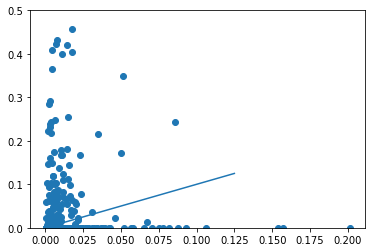

In [79]:
plt.ylim((0,0.5))
plt.scatter(ground_truth, inferences)

plt.plot(np.linspace(0,0.125,100), np.linspace(0,0.125,100))

In [76]:
np.max(ground_truth)

0.20121819641732097

In [80]:
run_experiment(lmbda=1000000, num_topics=10)

-0.009036407813458058

'error:'

6.653685025929879

'error:'

7.2458997843936155

'error:'

7.005226466588741

'error:'

7.2374916469015345

'error:'

6.963466038515198

'error:'

7.357215062806992

'error:'

7.3324728131522035

'error:'

7.383027404910948

'error:'

7.33615273174584

'error:'

7.295546135413062

'error:'

4.814443376236354

'error:'

4.841952715362605

'error:'

3.916962107884729

'error:'

3.845460438236389

'error:'

4.613492453773163

'error:'

4.808757519000902

'error:'

4.671553441414203

'error:'

4.847183996582426

'error:'

4.741696245312099

'error:'

4.673629577654044

'error:'

2.015405683565593

'error:'

1.9921257361638853

'error:'

1.9878568377436705

'error:'

1.9980284109846065

'error:'

1.9601267321926545

'error:'

1.9803093358384407

'error:'

1.992359270049378

'error:'

2.001016738094502

'error:'

1.9718080110784002

'error:'

1.9566636913629347

'error:'

1.780769175455402

'error:'

1.8281843910706328

'error:'

1.7811565428734824

'error:'

1.822053124941112

'error:'

1.8355198756132778

'error:'

1.8179027271790258

'error:'

1.7731638801549552

'error:'

1.8001033005297662

'error:'

1.8191112700517513

'error:'

1.7776945814539202

'error:'

1.665433101025223

'error:'

1.6631408360491957

'error:'

1.6387294845044227

'error:'

1.6505119447874697

'error:'

1.6702839149539745

'error:'

1.629186066872264

'error:'

1.628131222754701

'error:'

1.6317061256270118

'error:'

1.638076635371391

'error:'

1.63155385780375

'error:'

1.530440647944927

'error:'

1.5294337487262089

'error:'

1.4820915608862628

'error:'

1.5338100139008344

'error:'

1.498678884900272

'error:'

1.5468102901344738

'error:'

1.5121171279310783

'error:'

1.5326523941665349

'error:'

1.5509656302883674

'error:'

1.5470293295778192

'error:'

1.3921619069438675

'error:'

1.3987441827267129

'error:'

1.394264796132914

'error:'

1.4111529014566606

'error:'

1.3806192093911884

'error:'

1.3893047283641349

'error:'

1.3692500568299781

'error:'

1.3966190449292515

'error:'

1.3896868263656776

'error:'

1.3870295526203806

'error:'

1.2802784407005467

'error:'

1.2921932318891787

'error:'

1.303596052652122

'error:'

1.2922319981469763

'error:'

1.2542424896195545

'error:'

1.2835399561854883

'error:'

1.2767529415131367

'error:'

1.2782030314608832

'error:'

1.2777562873284143

'error:'

1.2815188074435282

'error:'

1.177442711618712

'error:'

1.1777491588249855

'error:'

1.1539042995086501

'error:'

1.1645557400380466

'error:'

1.202768473721038

'error:'

1.1481312670463293

'error:'

1.1736459542952973

'error:'

1.1706235527226416

'error:'

1.1815265377093775

'error:'

1.1773441113318546

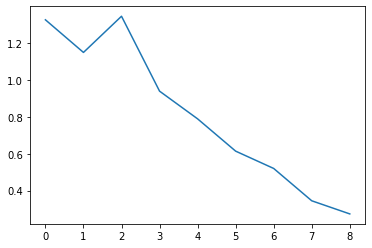

In [29]:
plt.plot([run_experiment(10,n_topics,trials=10) for n_topics in range(1,10)])
plt.show()